In [1]:
import numpy as np
import joblib
import json
import librosa
from PIL import Image
from tensorflow.keras.models import load_model


In [2]:
CANONICAL = ["angry","disgust","fear","happy","neutral","sad","surprise"]


In [4]:
# Image
image_model = load_model(r"F:\Multimodal_Emotion_Detection\models\02mobilenetv2_emotion_base.h5")
image_classes = json.load(open(r"F:\Multimodal_Emotion_Detection\models\class_labels.json"))

# Speech
speech_model = joblib.load(r"F:\Multimodal_Emotion_Detection\models\speech_emotion_rf.pkl")
speech_le = joblib.load(r"F:\Multimodal_Emotion_Detection\models\speech_label_encoder.pkl")
speech_classes = list(speech_le.classes_)

# Text
text_model = joblib.load(r"F:\Multimodal_Emotion_Detection\models\text_emotion_model.pkl")
text_tfidf = joblib.load(r"F:\Multimodal_Emotion_Detection\models\tfidf_vectorizer.pkl")
text_le = joblib.load(r"F:\Multimodal_Emotion_Detection\models\label_encoder.pkl")
text_classes = list(text_le.classes_)


In [5]:
def align_proba(proba, model_classes):
    model_classes = [c.lower() for c in model_classes]
    idx = {c:i for i,c in enumerate(model_classes)}
    aligned = np.zeros(len(CANONICAL))
    for i,c in enumerate(CANONICAL):
        aligned[i] = proba[idx[c]]
    return aligned


In [6]:
def predict_image(img_path):
    img = Image.open(img_path).convert("L").resize((224,224))
    arr = np.array(img, dtype=np.float32)
    arr = np.stack([arr, arr, arr], axis=-1) / 255.0
    x = np.expand_dims(arr, axis=0)

    proba = image_model.predict(x)[0]
    proba = align_proba(proba, image_classes)

    label = CANONICAL[np.argmax(proba)]
    return label, np.max(proba), proba


In [7]:
def predict_speech(wav_path):
    audio, sr = librosa.load(wav_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    feat = np.mean(mfcc.T, axis=0).reshape(1,-1)

    proba = speech_model.predict_proba(feat)[0]
    proba = align_proba(proba, speech_classes)

    label = CANONICAL[np.argmax(proba)]
    return label, np.max(proba), proba


In [8]:
def predict_text(text):
    X = text_tfidf.transform([text])
    proba = text_model.predict_proba(X)[0]
    proba = align_proba(proba, text_classes)

    label = CANONICAL[np.argmax(proba)]
    return label, np.max(proba), proba


In [9]:
from collections import Counter

def majority_vote(preds):
    labels = [p[0] for p in preds]
    return Counter(labels).most_common(1)[0][0]


In [10]:
def weighted_fusion(probas, weights):
    fused = sum(weights[m] * probas[m] for m in probas) / sum(weights.values())
    return CANONICAL[np.argmax(fused)], np.max(fused), fused


In [29]:
img_label, img_conf, img_p = predict_image(r"F:\Multimodal_Emotion_Detection\data\image\fer2013\test\sad\PrivateTest_552501.jpg")
aud_label, aud_conf, aud_p = predict_speech(r"F:\Multimodal_Emotion_Detection\data\speech\Audio\Sad\OAF_bath_sad.wav")
txt_label, txt_conf, txt_p = predict_text("there is a ghost inside the house!")

print("Image:", img_label)
print("Speech:", aud_label)
print("Text:", txt_label)

weights = {"image":0.4, "speech":0.3, "text":0.3}
final_label, final_conf, fused = weighted_fusion(
    {"image":img_p, "speech":aud_p, "text":txt_p}, weights
)

print("FUSED:", final_label, final_conf)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Image: sad
Speech: sad
Text: fear
FUSED: sad 0.4854829841562732


In [32]:
# Only text
label, conf, p = predict_text("yup! its a fantastic weekend!")
print(label, conf)

# Image + text only
final_label, final_conf, fused = weighted_fusion(
    {"image": img_p, "text": txt_p},
    {"image":0.6, "text":0.4}
)
print(final_label)


neutral 0.27254471542097786
sad


In [31]:
print("Image:", img_label)
print("Speech:", aud_label)
print("Text:", txt_label)
print("Fused:", final_label)


Image: sad
Speech: sad
Text: fear
Fused: sad


In [33]:
FUSION_WEIGHTS = {
    "image": 0.4,
    "speech": 0.3,
    "text": 0.3
}


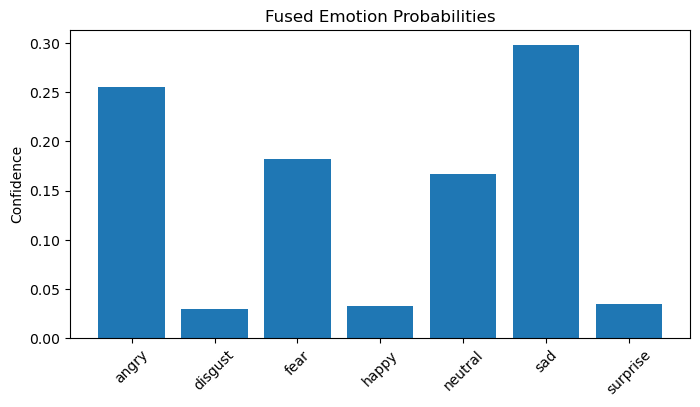

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(CANONICAL, fused)
plt.title("Fused Emotion Probabilities")
plt.ylabel("Confidence")
plt.xticks(rotation=45)
plt.show()
